In [1]:
using DifferentialEquations, OrdinaryDiffEq, LinearAlgebra, Sundials, DASSL, Distributions, NLsolve, OffsetArrays, CPUTime, TickTock, JLD2, FileIO, Plots, Plots.PlotMeasures, LaTeXStrings 

# **Parameters**

We are solving the kinetic equation for a single phonon frequency. In this notebook, the step size of the discrete energy grid is denoted as $\epsilon$. The energy cutoff is denoted as $N\epsilon$; in other words, the quantity referred to as $L$ in the supplemental material is labeled $N$ here. Here we have $N\epsilon \gg \{T,T_{0}\}_\mathrm{max}$. 

Here we consider Einstein (dispersionless) phonons with frequency $\Omega = r\epsilon$. We keep $N/r = 10$ for all our simulations. Also, in our energy units $(g = \lambda\Omega^2 = 1)$, fixing $\Omega$ immediately fixes the dimensionless electron-phonon coupling constant $\lambda$. 

Initially, we consider the distribution to be the Fermi distribution with temperature $T = T_{0} + \Delta T$. The distribution functions then quickly (we consider $t_\mathrm{end} = 20.0$) relax to equilibrium Fermi distribution with temperature $T_{0}$ when $\lambda < 1.27$. If we choose $\Omega$ so that $\lambda > 1.27$, the distribution function show unstable behavior --- see Fig. 1 of the main text.

The data to generate Fig. 1(a) is found in the folder "Data_Fig_1_Main_Text/Unstable". The data to generate Fig. 1(b) is found in the folder "Data_Fig_1_Main_Text/Stable" 

In [82]:
N = 500; r = 50; ϵ = 1.000/r; Ω = r * ϵ; 

T₀ = 0.20; 
ΔT = 1e-2; # (0.25/T₀) - 1.0; 
T = (1 + ΔT) * T₀;

# **Define All the Functions** 

## **This function finds an element of an array $A$ that is closest to a real number $T$**

In [30]:
function find_closest(A::AbstractArray{T}, b::T) where {T<:Real}
    if length(A) <= 1
        return firstindex(A)
    end

    i = searchsortedfirst(A, b)

    if i == firstindex(A)
        return i
    elseif i > lastindex(A)
        return lastindex(A)
    else
        prev_dist = b - A[i-1]
        next_dist = A[i] - b

        if prev_dist < next_dist
            return i - 1
        else
            return i
        end
    end
end

find_closest (generic function with 1 method)

## **Define the $(N+1) \times N$ dimensional $\gamma$ matrix: $\gamma[k,m] = \begin{cases} \frac{k}{\Omega \left( k^2 - m^2 \right)}, \quad \textrm{if } k \neq m, \\ 0, \quad \textrm{if } k = m \end{cases}$**

In [ ]:
@inline function Fill_γ!( γ, N, Ω )
    
    for k = 1 : (N+1)
        
        for m = 1 : N
            
            if m == k
                
                γ[k,m] = 0;
                
            else
                
                γ[k,m] = k / ( Ω * (k^2 - m^2) );
                
            end
            
        end
        
    end
    
end

## **Define the augmented "f" that takes care of the boundary conditions**

In [5]:
@inline function f_Aug( f, N, r )
    
    f_Aug_List = zeros(N+r+1); # f[0] = 0.5, f[N+1] = f[N+2] = ... = f[N+r] = 0
    
    f_Aug_List[1] = 0.5;
    
    for k = 2 : (N+1)
        
        f_Aug_List[k] = f[k-1];
        
    end
    
    Of_Aug = OffsetVector( f_Aug_List, 0:(N+r) );
    
    return Of_Aug 
    
end    

f_Aug (generic function with 1 method)

## **Define the augmented "df"s that takes care of the boundary conditions**

In [6]:
@inline function df_Aug( df, N, r )
    
    df_Aug_List = zeros(N+r+1); # df[0] = 0, df[N+1] = df[N+2] = ... = df[N+r] = 0
    
    for k = 2 : (N+1)
        
        df_Aug_List[k] = df[k-1];
        
    end
    
    Odf_Aug = OffsetVector( df_Aug_List, 0:(N+r) );
    
    return Odf_Aug 
    
end   

df_Aug (generic function with 1 method)

## **Define the $(N+1)$-Dimensional Array $\Sigma$**  

In [7]:
@inline function Σ_Array!( f, γ, N, r, Ω )
    
    f = f_Aug( f, N, r ); # Augment the array to take care of the boundary conditions
   
    Σ = zeros(N+1); # There is Σ_{k+1} in the equation! For k = N, we need Σ_{N+1}
    
    for k = 1 : (N+1)
        
        Σ[k] = ( ( 2.0*f[r] - 1.0 ) / (2.0*k*Ω) );
        
        ##################################
        # k = 1, ..., r-1
        
        for m = 1 : (r-1)
            
            Σ[k] += ( f[m+r] + f[r-m] - 1 ) * γ[k,m];
            
        end
        ##################################
        
        ##################################
        # k = r, ..., N
        
        for m = r : N
            
            Σ[k] += ( f[m+r] - f[m-r] ) * γ[k,m];
            
        end
        ##################################
        
    end
    
    return Σ
    
end

Σ_Array! (generic function with 1 method)

## **Define the $N$-Dimensional Array $d\Sigma$**

In [8]:
@inline function dΣ_Array!( df, γ, N, r, Ω )
    
    df = df_Aug( df, N, r ); # Augment the array to take care of the boundary conditions
   
    dΣ = zeros(N); 
    
    for k = 1 : N
        
        dΣ[k] = ( ( 2.0*df[r] ) / (2.0*k*Ω) );
        
        ##################################
        # k = 1, ..., r-1
        
        for m = 1 : (r-1)
            
            dΣ[k] += ( df[m+r] + df[r-m] ) * γ[k,m];
            
        end
        ##################################
        
        ##################################
        # k = r, ..., N
        
        for m = r : N
            
            dΣ[k] += ( df[m+r] - df[m-r] ) * γ[k,m];
            
        end
        ##################################
        
    end
    
    return dΣ
    
end

dΣ_Array! (generic function with 1 method)

## **Define the $N$-Dimensional Array b. This corresponds to the RHS of the system of ODEs.**

In [9]:
@inline function b_Array!( f, N, r, T₀ )
    
    f         = f_Aug( f, N, r ); # Augment the array to take care of the boundary conditions
   
    b         = zeros(N); 
    
    f_Bose_T₀ = 1 / ( exp(Ω/T₀) - 1.0 );
    
    ##################################
    # k = 1, ..., r-1
    
    for k = 1 : (r-1)
        
        b[k] = ( f_Bose_T₀ * ( f[k+r] + 1 - f[r-k] - (2.0*f[k]) ) ) + ( f[k+r] - f[k] ) - ( f[k] * ( f[k+r] - 1 + f[r-k] ) );
        
    end
    ##################################
    
    ##################################
    # k = r, ..., N
    
    for k = r : N
        
        b[k] = ( f_Bose_T₀ * ( f[k+r] + f[k-r] - (2.0*f[k]) ) ) + ( f[k+r] - f[k] ) - ( f[k] * ( f[k+r] - f[k-r] ) );
        
    end
    ##################################
    
    return b
    
end

b_Array! (generic function with 1 method)

## **Define the ODE Problem. To be solved with DAEProblem.**

In [10]:
@inline function EYBA_SC( out, du, u, p, t )
    
    b  = b_Array!( u, N, r, T₀ ); # Note the first line in b_Array!( f, N, r, T₀ ). 
                                  # It takes 'f' and augments it.  
    
    Σ  = Σ_Array!( u, γ, N, r, Ω ); # Note the first line in Σ_Array!( r, γ, N, r, Ω ). 
                                    # It takes 'f' and augments it.
    
    dΣ = dΣ_Array!( du, γ, N, r, Ω ); # Note the first line in dΣ_Array!( r, γ, N, r, Ω ). 
                                      # Similar to Σ_Array!, it takes 'f' and augments it.
    
    ### NEED to augment u, since u[N+1] appears.
    
    u  = f_Aug( u, N, r ); # Augment the array to take care of the boundary conditions
    
    ######################################################################################################################

    # The special intial conditions

    u₀ = zeros(N);

    for k = 1 : N
    
        u₀[k] = 1.0 / ( exp( (k*ϵ) / T ) + 1.0 );
    
    end

    # The Σ array corresponding to the special intial conditions

    Σ₀ = Σ_Array!( u₀, γ, N, r, Ω );

    ######################################################################################################################
    ######################################################################################################################
    ######################################################################################################################
    
    ##################################
    # The LHS is the same for k = 1, ..., N
    
    for k = 1 : N
        
        out[k] = b[k] - ( Ω - r*(Σ[k+1] - Σ[k]) ) * du[k] - r * ( u[k+1] - u[k] ) * dΣ[k]; # This is the full problem
        
        # out[k] = b[k] - ( Ω - r*(Σ[k+1] - Σ[k]) ) * du[k]; # Here we assume that dΣ = 0
        
        # out[k] = b[k] - ( Ω - r*(Σ₀[k+1] - Σ₀[k]) ) * du[k]; # Here we assume that dΣ = 0. We also replace Σ by Σ₀.  
        
        # out[k] = b[k] -  Ω * du[k]; # Here we assume that Σ = 0
        
    end
    ##################################
    
end

EYBA_SC (generic function with 1 method)

# **Initial Conditions**

## **Fermi Distributed Initial Conditions**

In [83]:
######################################################################################################################

# The special intial conditions

u₀ = zeros(N);

for k = 1 : N
    
    u₀[k] = 1.0 / ( exp( (k*ϵ) / T ) + 1.0 );
    
end

# The Σ array corresponding to the special intial conditions

γ = zeros( (N+1), N ); Fill_γ!( γ, N, Ω );

Σ₀ = Σ_Array!( u₀, γ, N, r, Ω );

######################################################################################################################
######################################################################################################################
######################################################################################################################

######################################################################################################################
    ### Solving the corresponding system of linear equations to obtain the initial values of the derivatives ### 
######################################################################################################################

# Defining the RHS

b₀ = b_Array!( u₀, N, r, T₀ );

# Writing the system of equations

@inline function Init_Conds_Constraints!(F, x)
    
    for k = 1 : N
        
        u₀_Aug = f_Aug( u₀, N, r ); # Augment the array to take care of the boundary conditions
        
        ##################################################################################################################################################################
        ### FULL PROBLEM ###
        ##################################################################################################################################################################
        
        ######################################################################################################
        ### Defining the dΣ part functionally ###

        dΣ₀_k = x[r] / (k*Ω);

        ##################################
        # k = 1, ..., r-1; assuming (2r-1) < N always

        for m = 1 : (r-1)

            dΣ₀_k += ( x[m+r] + x[r-m] ) * γ[k,m];

        end
        ##################################
        
        dΣ₀_k += x[2*r] * γ[k,r]; # This expression corresonds to m = r, which results in df[0] = d(0.5) = 0!

        ##################################
        # k = (r+1), ..., (N-r)

        for m = (r+1) : (N-r)

            dΣ₀_k += ( x[m+r] - x[m-r] ) * γ[k,m];

        end
        ##################################

        ##################################
        # k = (N-r+1), ..., N

        for m = (N-r+1) : N

            dΣ₀_k += - x[m-r] * γ[k,m];

        end
        ##################################

        ######################################################################################################
        ######################################################################################################
        
        F[k] = b₀[k] - ( Ω - r*(Σ₀[k+1] - Σ₀[k]) ) * x[k] - r * ( u₀_Aug[k+1] - u₀_Aug[k] ) * dΣ₀_k; # This is the full problem
            
        ##################################################################################################################################################################
        ################################################################################################################################################################## 
        ##################################################################################################################################################################
        
        
        
#         ##################################################################################################################################################################
#         ### dΣ = 0 ###
#         ##################################################################################################################################################################
        
#         F[k] = b₀[k] - ( Ω - r*(Σ₀[k+1] - Σ₀[k]) ) * x[k]; # Here we assume that dΣ = 0
        
#         ################################################################################################################################################################## 
#         ################################################################################################################################################################## 
#         ##################################################################################################################################################################
        
        
        
#         ##################################################################################################################################################################
#         ### Σ = 0 ###
#         ##################################################################################################################################################################
        
#         F[k] = b₀[k] - Ω * x[k]; # Here we assume that Σ = 0
        
#         ################################################################################################################################################################## 
#         ################################################################################################################################################################## 
#         ################################################################################################################################################################## 
        
    end
    
end


x   = nlsolve(Init_Conds_Constraints!, zeros(N), autodiff = :forward);

du₀ = x.zero;

######################################################################################################################
######################################################################################################################
######################################################################################################################

######################################################################################################################

# du₀ = rand(N); # Provide random values. The algorithm solve for the initial conditions also!
                 # Sometimes works, sometimes does not!

tspan = (0.0, 20.0); 

######################################################################################################################
######################################################################################################################
######################################################################################################################

######################################################################################################################

### differential_vars needed for IDA() ###

differential_vars = trues(N); # None of the equations are purely algebraic!
prob = DAEProblem(EYBA_SC, du₀, u₀, tspan, differential_vars = differential_vars);

######################################################################################################################
######################################################################################################################
######################################################################################################################

DAEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 20.0)
u0: 500-element Vector{Float64}:
 0.4752677255779987
 0.45065618272604646
 0.4262837570425201
 0.40226423839138836
 0.37870475684473504
 0.3557039811097066
 0.3333506388088762
 0.3117223976060625
 0.2908851247299718
 0.27089252178498463
 ⋮
 6.986647019877185e-22
 6.328041937597487e-22
 5.731521093031576e-22
 5.191232037305066e-22
 4.701874010008819e-22
 4.258645933590975e-22
 3.8571993101229014e-22
 3.4935955583110143e-22
 3.1642673721886454e-22
du0: 500-element Vector{Float64}:
  1.0779196984323138e-5
  9.116869129017156e-6
  5.388162796636872e-6
  9.487018495995598e-7
 -3.922717497514725e-6
 -9.316455531508123e-6
 -1.543592083882814e-5
 -2.2526778634427758e-5
 -3.086075708667068e-5
 -4.072960903328425e-5
  ⋮
 -3.911862827353485e-23
 -3.5429546748278316e-23
 -3.2088372478770574e-23
 -2.906229441262089e-23
 -2.6321595988292605e-23
 -2.3839363277058075e-23
 -2.1591220652617398e-23
 -1.955509139

# **Solving the ODE**

In [84]:
# MAXITERS = 1e5;

# Advanced step-size control does not work for Sundials.jl!

# If corrector convergence test fails, increase the tolerance. 

# @time sol = solve(prob, alg_hints=[:stiff], dtmin = 1e-2, force_dtmin = true) # Does not help. IDA() is chosen by default!

# @time sol = solve(prob, dassl(), alg_hints=[:stiff])

# @time sol = solve(prob, daskr()) # Error Message: UndefVarError: lib not defined

######################################################################################################################

##################################################################
### The default arguments of the IDA solver. ###
##################################################################

# IDA(;linear_solver=:Dense,jac_upper=0,jac_lower=0,krylov_dim=0,
#     max_order = 5,
#     max_error_test_failures = 7,
#     max_nonlinear_iters = 3,
#     nonlinear_convergence_coefficient = 0.33,
#     nonlinear_convergence_coefficient_ic = 0.0033,
#     max_num_steps_ic = 5,
#     max_num_jacs_ic = 4,
#     max_num_iters_ic = 10,
#     max_num_backs_ic = 100,
#     use_linesearch_ic = true,
#     max_convergence_failures = 10,
#     init_all = false,
#     prec = nothing, psetup = nothing)

# Default abstol = 1e-6, reltol = 1e-3.

##################################################################
##################################################################
##################################################################

@time sol = solve( prob, IDA(; linear_solver=:Dense,jac_upper=0,jac_lower=0,krylov_dim=0,
                            max_order = 3,                                        # Order of the backward diff formula
                            max_error_test_failures = 3,                          # Maximum no. of error test failures
                            max_nonlinear_iters = 2,                              # Maximum no. of nonlinear iterations (Newton-Raphson) = m
                            nonlinear_convergence_coefficient = 0.33,             # δₘ = yₙ - yₙₘ; R = (δₘ/δ₁)^(1/(m-1)); R/(R-1)||δₘ|| < nonlinear_convergence_coefficient 
                            # nonlinear_convergence_coefficient_ic = 0.0033,      # positive constant in the Newton iteration convergence test within the initial condition calculation.
                            # max_num_steps_ic = 5,                               # Apparently there is no need to give precise values of the init. cond.  
                            # max_num_jacs_ic = 4,                                # maximum number of the approx Jacobian or precond evals allowed when the Newton iteration appears to be slowly converging
                            # max_num_iters_ic = 10,                              # maximum number of Newton iterations allowed in any one attempt to solve the initial conditions calculation problem
                            # max_num_backs_ic = 100,                             # Commented out by the developer in the source code. Related to lineserach backtrack in the init cond.
                            use_linesearch_ic = true,
                            max_convergence_failures = 3,                         # maximum number of nonlinear solver convergence failures in one step
                            init_all = false,
                            prec = nothing, psetup = nothing),
                            # maxiters = Int(2e5), abstol = 1e-9, reltol = 1e-9,
                            alg_hints=[:stiff] )

######################################################################################################################
######################################################################################################################
###################################################################################################################### 

  4.888740 seconds (56.53 M allocations: 1.068 GiB, 0.93% gc time)


retcode: Success
Interpolation: 3rd order Hermite
t: 20-element Vector{Float64}:
  0.0
  0.018092897596586624
  0.03618579519317325
  0.0723715903863465
  0.144743180772693
  0.289486361545386
  0.434229542318079
  0.578972723090772
  0.868459084636158
  1.157945446181544
  1.736918169272316
  2.315890892363088
  2.89486361545386
  4.052809061635404
  5.210754507816948
  7.526645400180036
  9.842536292543123
 12.15842718490621
 16.79020896963239
 20.0
u: 20-element Vector{Vector{Float64}}:
 [0.4752677255779987, 0.45065618272604646, 0.4262837570425201, 0.40226423839138836, 0.37870475684473504, 0.3557039811097066, 0.3333506388088762, 0.3117223976060625, 0.2908851247299718, 0.27089252178498463  …  7.713797895418379e-22, 6.986647019877185e-22, 6.328041937597487e-22, 5.731521093031576e-22, 5.191232037305066e-22, 4.701874010008819e-22, 4.258645933590975e-22, 3.8571993101229014e-22, 3.4935955583110143e-22, 3.1642673721886454e-22]
 [0.4752679130535393, 0.45065632257740684, 0.4262838064140039, 

In [85]:
Time_Stamp = sol.t;

In [86]:
Time_Stamp[length(Time_Stamp)]

20.0

## **Solving the data for $\lambda < \lambda_{c}$**

## Need to change the path if necessary. Here we are saving it in the folder **Data_Fig_1_Main_Text**

In [87]:
@save "Data_Fig_1_Main_Text/Stable/Sol_$(N)_Ω_$(Ω)_T_$(T)"*".jld2" N r ϵ sol Time_Stamp;

# Here change the path for saving the data.

## **Solving the data for $\lambda > \lambda_{c}$**

## Need to change the path if necessary. Here we are saving it in the folder **Data_Fig_1_Main_Text**

In [ ]:
@save "Data_Fig_1_Main_Text/Unstable/Sol_$(N)_Ω_$(Ω)_T_$(T)"*".jld2" N r ϵ sol Time_Stamp;

# Here change the path for saving the data.

# **Test: Plotting the Solutions: $f(E,t) vs E$**

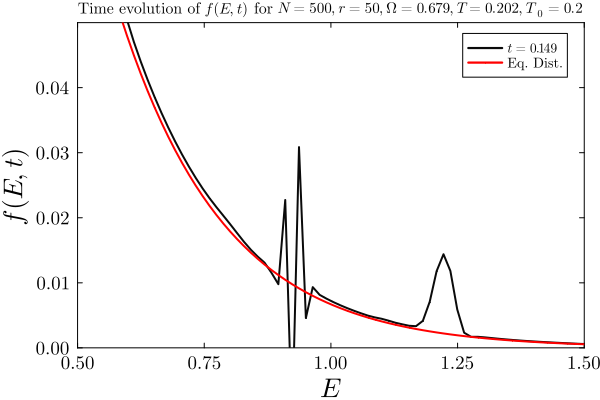

In [67]:
######################################################################################################################

# The special intial conditions

uFin = zeros(N);

for k = 1 : N
    
    uFin[k] = 1.0 / ( exp( (k*ϵ) / T₀ ) + 1.0 );
    
end

######################################################################################################################
######################################################################################################################


######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

msv = 0; lwv = 2; tickf = 12; titlef = 10; guidef = 18; legendf = 9; ERange = (1:1:N);

t_last = Int( length(sol[1,:]) ); t_penultim = Int( length(sol[1,:]) ) - 102; # t_ppenultim = Int( length(sol[1,:]) ) - 102;

plot( ϵ.*ERange, sol[:,t_last],  
    shape=:circle, ms=msv, mc=:grey4, msc=:grey4, lw=lwv, linestyle=:solid, linecolor=:grey4,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label=latexstring("\$ t = $( round(sol.t[t_last]; digits=3) ) \$"), legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=0mm, rightmargin=2mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################


######################################################################################################################################
######################################################################################################################################
######################################################################################################################################


plot!( ϵ.*ERange, uFin,  
    shape=:circle, ms=msv, mc=:red, msc=:red, lw=lwv, linestyle=:solid, linecolor=:red,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label="Eq. Dist.", legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=0mm, rightmargin=2mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

title!("Time evolution of " * L"f(E,t)" * " for " 
    * latexstring("\$ N = $( N ), r = $( r ), \\Omega = $( round(Ω; digits=6) ), T = $( round(T; digits=3) ), T_{0} = $( round(T₀; digits=3) ) \$"))

ylabel!( L"f(E,t)" )
xlabel!( L"E")

xlims!( 0.5, 1.5 )
ylims!( 0, 5e-2 )


# **Plotting the Solutions**

## **Loading the files for $\lambda > \lambda_c$ with $N = 400, 500, 800$**

In [88]:
f1 = jldopen("Data_Fig_1_Main_Text/Unstable/Sol_400_Ω_0.679_T_0.202.jld2"); 

f2 = jldopen("Data_Fig_1_Main_Text/Unstable/Sol_500_Ω_0.679_T_0.202.jld2");

f3 = jldopen("Data_Fig_1_Main_Text/Unstable/Sol_800_Ω_0.679_T_0.202.jld2");

### **Equilibrium Distribution for $N = 800$**

In [89]:
######################################################################################################################

# The special intial conditions

N3 = 800; r3 = 80; ϵ3 = 0.679/r3; T₀ = 0.20;

uFin = zeros(N3);

for k = 1 : N3
    
    uFin[k] = 1.0 / ( exp( (k*ϵ3) / T₀ ) + 1.0 );
    
end

######################################################################################################################
######################################################################################################################

### **Finding the appropriate time indexes for $N = 400, 500, 800$**

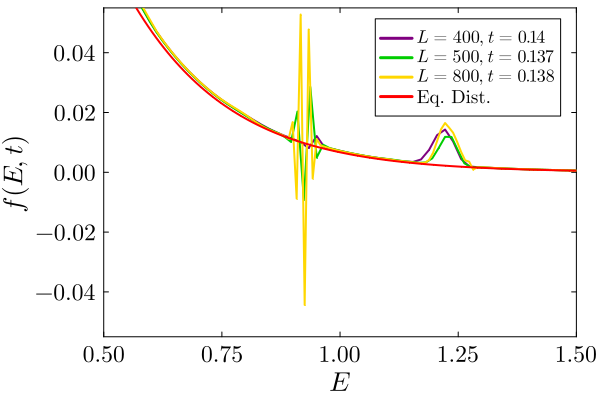

In [90]:
msv = 0; lwv = 2; tickf = 15; titlef = 10; guidef = 18; legendf = 12; 

# E_Left = 0.93;
# E_Right = 1.30; 

# plot([E_Right, E_Right], [-5.5e-2, 5.5e-2],
#       lw=2, linestyle=:dash, linecolor=:black, legend=:false )

# plot!([E_Left, E_Left], [-5.5e-2, 5.5e-2],
#       lw=2, linestyle=:dash, linecolor=:black, legend=:false )

######################################################################################################################################

plot( f1["ϵ"].*( 1:1:Int(f1["N"]) ), f1["sol"][ :, find_closest(f1["Time_Stamp"], 0.138) ],  
    shape=:circle, ms=msv, mc=:purple, msc=:purple, lw=lwv, linestyle=:solid, linecolor=:purple,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label=latexstring("\$ L = $( Int(f1["N"]) ), t = $( round(f1["Time_Stamp"][find_closest(f1["Time_Stamp"], 0.138)]; digits=3) ) \$"), 
    legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=2mm, rightmargin=4mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

######################################################################################################################################

plot!( f2["ϵ"].*( 1:1:Int(f2["N"]) ), f2["sol"][ :, find_closest(f2["Time_Stamp"], 0.138) ],  
    shape=:circle, ms=msv, mc=:green3, msc=:green3, lw=lwv, linestyle=:solid, linecolor=:green3,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label=latexstring("\$ L = $( Int(f2["N"]) ), t = $( round(f2["Time_Stamp"][find_closest(f2["Time_Stamp"], 0.138)]; digits=3) ) \$"), 
    legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=2mm, rightmargin=4mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

######################################################################################################################################

plot!( f3["ϵ"].*( 1:1:Int(f3["N"]) ), f3["sol"][ :, find_closest(f3["Time_Stamp"], 0.138) ],  
    shape=:circle, ms=msv, mc=:gold1, msc=:gold1, lw=lwv, linestyle=:solid, linecolor=:gold1,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label=latexstring("\$ L = $( Int(f3["N"]) ), t = $( round(f3["Time_Stamp"][find_closest(f3["Time_Stamp"], 0.138)]; digits=3) ) \$"), 
    legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=2mm, rightmargin=4mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

######################################################################################################################################

plot!( f3["ϵ"].*( 1:1:Int(f3["N"]) ), uFin,  
    shape=:circle, ms=msv, mc=:red, msc=:red, lw=lwv, linestyle=:solid, linecolor=:red,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label="Eq. Dist.", legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=2mm, rightmargin=4mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

# # title!("Time evolution of " * L"f(E,t)" * " for " 
# #     * latexstring("\$ \\Omega = $( round(Ω; digits=6) ), T = $( round(T; digits=3) ), T_{0} = $( round(T₀; digits=3) ) \$"))

ylabel!( L"f(E,t)" )
xlabel!( L"E")

xlims!( 0.5, 1.5 )
ylims!( -5.5e-2, 5.5e-2 )

In [91]:
savefig("Data_Fig_1_Main_Text/Unstable.pdf")

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Metallic_Instability_El-Ph_Interaction/Data_Fig_1_Main_Text/Unstable.pdf"

## **Plotting $f(E,t)$ vs $E$ for $t = 1000.0$ in the stable case**

### **Loading the files for $N = 400, 500, 800$**

In [92]:
f1 = jldopen("Data_Fig_1_Main_Text/Stable/Sol_400_Ω_1.0_T_0.202.jld2"); 

f2 = jldopen("Data_Fig_1_Main_Text/Stable/Sol_500_Ω_1.0_T_0.202.jld2");

f3 = jldopen("Data_Fig_1_Main_Text/Stable/Sol_800_Ω_1.0_T_0.202.jld2");

### **Equilibrium Distribution for $N = 800$**

In [93]:
######################################################################################################################

# The special intial conditions

N3 = 800; r3 = 80; ϵ3 = 1.0/r3; T₀ = 0.20;

uFin = zeros(N3);

for k = 1 : N3
    
    uFin[k] = 1.0 / ( exp( (k*ϵ3) / T₀ ) + 1.0 );
    
end

######################################################################################################################
######################################################################################################################

######################################################################################################################

uInit = zeros(N3);

for k = 1 : N3
    
    uInit[k] = 1.0 / ( exp( (k*ϵ3) / T ) + 1.0 );
    
end

######################################################################################################################
######################################################################################################################

### **Finding the appropriate time indexes for $N = 400, 500, 800$**

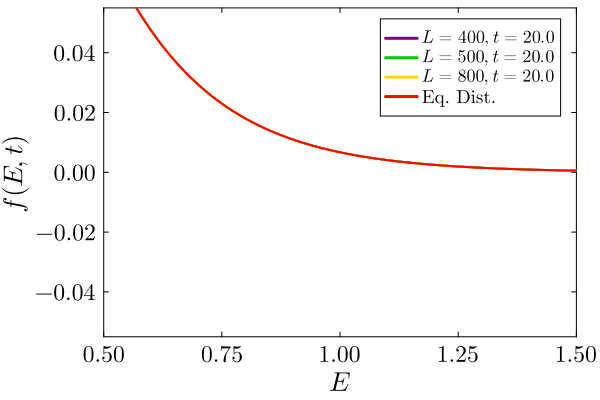

In [94]:
msv = 0; lwv = 2; tickf = 15; titlef = 10; guidef = 18; legendf = 12;  

######################################################################################################################################

plot( f1["ϵ"].*( 1:1:Int(f1["N"]) ), f1["sol"][ :, length( f1["Time_Stamp"] ) ],  
    shape=:circle, ms=msv, mc=:purple, msc=:purple, lw=lwv, linestyle=:solid, linecolor=:purple,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label=latexstring("\$ L = $( Int(f1["N"]) ), t = $( round(f1["Time_Stamp"][length( f1["Time_Stamp"] )]; digits=3) ) \$"), 
    legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=2mm, rightmargin=4mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

######################################################################################################################################

plot!( f2["ϵ"].*( 1:1:Int(f2["N"]) ), f2["sol"][ :, length( f2["Time_Stamp"] ) ],  
    shape=:circle, ms=msv, mc=:green3, msc=:green3, lw=lwv, linestyle=:solid, linecolor=:green3,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label=latexstring("\$ L = $( Int(f2["N"]) ), t = $( round(f2["Time_Stamp"][length( f2["Time_Stamp"] )]; digits=3) ) \$"), 
    legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=2mm, rightmargin=4mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

######################################################################################################################################

plot!( f3["ϵ"].*( 1:1:Int(f3["N"]) ), f3["sol"][ :, length( f3["Time_Stamp"] ) ],  
    shape=:circle, ms=msv, mc=:gold1, msc=:gold1, lw=lwv, linestyle=:solid, linecolor=:gold1,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label=latexstring("\$ L = $( Int(f3["N"]) ), t = $( round(f3["Time_Stamp"][length( f3["Time_Stamp"] )]; digits=3) ) \$"), 
    legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=2mm, rightmargin=4mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

######################################################################################################################################

plot!( ϵ3.*( 1:1:800 ), uFin,  
    shape=:circle, ms=msv, mc=:red, msc=:red, lw=lwv, linestyle=:solid, linecolor=:red,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label="Eq. Dist.", legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=2mm, rightmargin=4mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

# title!("Time evolution of " * L"f(E,t)" * " for " 
#     * latexstring("\$ \\Omega = $( round(Ω; digits=6) ), T = $( round(T; digits=3) ), T_{0} = $( round(T₀; digits=3) ) \$"))

ylabel!( L"f(E,t)" )
xlabel!( L"E")

xlims!( 0.5, 1.5 )
ylims!( -5.5e-2, 5.5e-2 )

In [95]:
savefig("Data_Fig_1_Main_Text/Stable.pdf")

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Metallic_Instability_El-Ph_Interaction/Data_Fig_1_Main_Text/Stable.pdf"

### **Comparing the initial and and final distribution for $N = 800$**

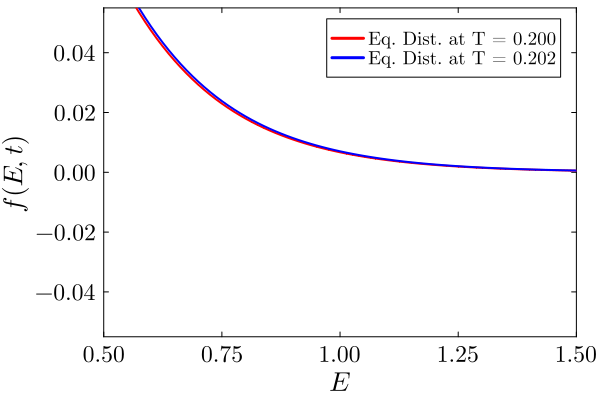

In [20]:
msv = 0; lwv = 2; tickf = 15; titlef = 10; guidef = 18; legendf = 12;  

######################################################################################################################################

plot( ϵ3.*( 1:1:800 ), uFin,  
    shape=:circle, ms=msv, mc=:red, msc=:red, lw=lwv, linestyle=:solid, linecolor=:red,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label="Eq. Dist. at T = 0.200", legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=2mm, rightmargin=4mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

######################################################################################################################################

plot!( ϵ3.*( 1:1:800 ), uInit,  
    shape=:circle, ms=msv, mc=:blue, msc=:blue, lw=lwv, linestyle=:solid, linecolor=:blue,
    tickfont=font(tickf,"Computer Modern"), titlefont = font(titlef,"Computer Modern"), 
    guidefont = font(guidef,"Computer Modern"), 
    framestyle = :box, grid = false,
    label="Eq. Dist. at T = 0.202", legend=:topright, legendfont=(legendf,"Computer Modern"),
    lefttmargin=2mm, topmargin=0mm, bottommargin=2mm, rightmargin=4mm)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################


# title!("Time evolution of " * L"f(E,t)" * " for " 
#     * latexstring("\$ \\Omega = $( round(Ω; digits=6) ), T = $( round(T; digits=3) ), T_{0} = $( round(T₀; digits=3) ) \$"))

ylabel!( L"f(E,t)" )
xlabel!( L"E")

xlims!( 0.5, 1.5 )
ylims!( -5.5e-2, 5.5e-2 )